# Import necessary libraries
---
MY EXPLANAION: Use of confusion_matrix in this code
The confusion matrix is a compact summary of classification results that shows how
many true class samples were predicted as each class. In a binary case (glioma vs no-tumor)
it looks like:
Predicted: NoTumor Predicted: Glioma
True: NoTumor TN FP
True: Glioma FN TP
Why it is useful here:
- It reveals types of errors (false positives vs false negatives). In medical tasks
this matters: a false negative (missing a tumor) is usually far more serious than a false positive.
- It allows computing clinically-relevant metrics (sensitivity/recall = TP/(TP+FN),
specificity = TN/(TN+FP), precision = TP/(TP+FP), F1-score).
- The classification_report uses the confusion matrix counts to compute per-class precision,
recall, and F1 — giving a more complete picture than overall accuracy.
- Visualizing the confusion matrix (heatmap) helps spot class imbalance or systematic bias
(e.g., model tends to predict one class more).
In the code: after predicting on the test set we build cm = confusion_matrix(y_true, y_pred)
and plot it. This helps you (and clinicians) to understand not only how often the model is wrong,
but how it is wrong — which drives decisions on thresholding, further training, or data collection.
MY EXPLANAION: What the validation set comprises of and its use during training
- Composition:
The validation set is a separate subset of the data not used for updating model weights.
In this project the structure used is three folders: Training/, Validation/, and Testing/.
The Validation/ folder should ideally be sampled from the same distribution as training
but kept distinct (no overlapping patients/images). It is used to monitor model behavior.
- Purpose / Use during training:
1. Hyperparameter selection & early stopping: Metrics computed on the validation set
(validation loss, validation accuracy) are used to tune things like learning rate,
regularization, number of layers, or to trigger EarlyStopping when the model stops
improving on unseen data. This prevents overfitting to the training set.
2. Model selection: If you train multiple models or checkpoints, you typically pick
the one with the best validation performance (not the one with best training performance).
3. Monitoring generalization: A growing gap between training and validation metrics
indicates overfitting. If both are poor — it indicates underfitting or bad model/capacity.
4. Tuning augmentation and preprocessing: You can observe whether augmentation helps by
seeing its effect on validation metrics.
- Important cautions:
* Validation data should not influence final model evaluation.* After selecting hyperparameters
using validation, you should evaluate the final chosen model only once on the independent test set.
*Ensure that validation images are independent (no images from same patient in both train/val/test)
to avoid optimistic estimates of generalization for medical datasets.
MY EXPLANAION: How the loss function is calculated here (with normalized images)
- Input normalization:
The code rescales image pixel values from the range [0, 255] to [0.0, 1.0] using
Rescaling(1./255). This keeps numeric values small and well-scaled for network training.
- Model outputs:
The network's final Dense layer produces raw numbers (logits) of size num_classes.
Because the model outputs logits, the loss used is SparseCategoricalCrossentropy(from_logits=True).
- Loss calculation mechanics:
For a single training example with true class index y (an integer 0..C-1) and model logits z (vector of length C):
1. Convert logits to unnormalized scores — they are already logits z.
2. Cross-entropy (sparse) uses the logit corresponding to the true class and the log-sum-exp across logits:
loss = - z_true + log( sum_j exp(z_j) )
3. When using from_logits=True, the loss function internally applies this numerically-stable
formulation (i.e., softmax + log combined) without requiring an explicit softmax layer.
The final batch loss is averaged over examples (and optionally weighted by class_weight).
- Role of normalization:
Normalizing inputs to [0,1] stabilizes gradients and improves training convergence; the cross-entropy
loss formula itself assumes nothing about pixel scale, but poorly scaled inputs can lead to vanishing/
exploding gradients or slow learning. Thus normalization is a best practice prior to computing loss.
MY EXPLANAION: Explain Cross-Entropy (intuition and math)
- Intuition:
Cross-entropy measures the discrepancy between two probability distributions: the true distribution
(a one-hot vector indicating the true class) and the predicted distribution (model's softmax probabilities).
It is the expected number of bits (or 'surprise') required to encode the true labels using the predicted distribution.
- For classification:
If p = true distribution (one-hot, with p_k = 1 for true class k) and q = predicted probabilities,
cross-entropy H(p, q) = - sum_k p_k * log q_k = - log q_true (since p is one-hot).
Therefore low loss means the model assigns high probability to the true class.
- Numeric form used with logits:
To avoid numeric instability, frameworks combine softmax and cross-entropy into a single operation:
CE(logits, y) = - z_y + log( sum_j exp(z_j) )
where z_j are logits. This is equivalent to -log( softmax(z)_y ).
- Properties:
- Non-negative: CE >= 0 (zero only when model assigns probability 1 to true class).
- Differentiable: gradients w.r.t logits are convenient: derivative of CE wrt z_i is (softmax(z)_i - p_i).
This simple form is why softmax + cross-entropy is widely used — gradient is predicted_prob - true_prob,
which is intuitive for gradient descent updates.
- In practice:
- With SparseCategoricalCrossentropy(from_logits=True), TensorFlow computes the numerically stable
version of CE on the raw logits, so you don't need to add Softmax in your model.
MY EXPLANAION: Why logits are used (and relation to logistic regression)
- What are logits:
Logits are raw, unconstrained scores output by the model (real numbers in (-inf, +inf)) for each class.
Converting logits to probabilities requires applying softmax:
probs = softmax(logits) = exp(logit_i) / sum_j exp(logit_j)
- Why output logits (instead of probabilities):
1. Numerical stability: Combining softmax and cross-entropy in one op (from_logits=True)
is more stable than computing softmax first (which can underflow/overflow) then cross-entropy.
2. Better gradient properties: The derivative of the loss simplifies to (predicted_prob - true_one_hot),
which is numerically stable and efficient when implemented from logits.
3. Flexibility in loss computation: For example, some advanced losses or objective functions
work directly with logits (e.g., temperature scaling, label smoothing, focal loss variants).
- Relation to logistic regression:
- For binary classification, logistic regression produces a single logit z; applying sigmoid gives
probability p = 1/(1+exp(-z)). Cross-entropy for binary classification is:
- y*log(p) - (1-y)*log(1-p)
which reduces to a stable expression when computed from logits.
- For multi-class problems (like our num_classes case), the softmax + cross-entropy generalizes logistic regression
to multiple classes (this is sometimes called multinomial logistic regression).
- Practical teaching note:
Always output logits from the model if you intend to use from_logits=True in the loss — this gives the
numerically stable computation and avoids needing an explicit Softmax layer in the model definition.
MY EXPLANAION: Short summary linking these pieces for your lesson
- The model predicts logits for each image; logits are converted internally (in the loss function)
to probabilities and then cross-entropy is computed against the true label.
- Validation set tracks whether this cross-entropy (and derived metrics like accuracy) decreases on unseen data,
guiding hyperparameter choices and early stopping.
- The confusion matrix on the final test set decomposes errors (false positives/negatives), which is vital
for interpreting clinical risk and for measuring sensitivity/specificity beyond raw accuracy.
- Normalizing images (0..1) is orthogonal to the cross-entropy math, but essential for stable network training.
If you want, I can now inject these comment blocks into the exact locations inside the annotated .py file
you provided (producing a new file), or produce a short slide/text snippet that you can use verbatim in your lecture.

In [4]:

%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

# Load data and preprocess it

## Upload the data to drive:
Download the dataset from Brigthspace, and upload it to the content folder in Google Colab.


###Option 1: To avoid having to upload the dataset every time, you can upload the dataset to your google drive, and then connect this virtual machine to your drive, and make a copy of your data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Replace the path /content/drive/MyDrive/Work/2025-CS3002/BrainTumorDataset.zip with your actual path where you copied the dataset in your drive.

In [9]:
# Does not work locally
#!cp /content/drive/MyDrive/Work/2025-CS3002/BrainTumorDataset.zip /content/

# GOING FOR OPTION#2 FOR LOCALLY SAVING

###Option 2: Upload the zip archive in the Files section of your virtual machine, under /content/

In [5]:
# After you have copied the data locally, point the dataset_url to the local path
dataset_url = 'content/BrainTumorDataset.zip'\

# Path to your local zip file
zip_path = dataset_url

# Path where you want to extract
out_path = "content/"

#This works for locally created folder 'content' (within codespace)
open("content/README.txt", "w").close()

try:
    open(dataset_url, "r").close()
    print("Dataset loaded: ", dataset_url)
except:
    print("ERROR!!! You need to copy the zip file at: ", dataset_url)

Dataset loaded:  content/BrainTumorDataset.zip


###After the data is loaded, let's start processing it.

In [6]:
'''
SKIP THIS - IF RUN ALREADY!
'''

import zipfile
import os

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(out_path)

print("Extraction complete. Files are in:", out_path)


Extraction complete. Files are in: content/


In [7]:
# Create a 'pathlib.Path' object for the downloaded archive
# Pathlib module offers classes representing filesystem paths with semantics
# appropriate for different operating systems.
# data_dir = pathlib.Path(archive).with_suffix('')

extract_dir = pathlib.Path(zip_path).with_suffix('')
# Now use Pathlib for further work
data_dir = pathlib.Path(extract_dir)

print("Data directory is:", data_dir)

Data directory is: content\BrainTumorDataset


In [8]:
# Count the number of images in a specific directory
image_count = len(list(data_dir.glob('Training/glioma/*.jpg')))
print("Training Image count: ", image_count)


for dir in data_dir.iterdir():
    print(dir)
## Too many to list!
# for ww in data_dir.walk():
#     print(ww)
## List files:
# list(data_dir.glob('Training/glioma/*.jpg'))


Training Image count:  500
content\BrainTumorDataset\.DS_Store
content\BrainTumorDataset\Testing
content\BrainTumorDataset\Training
content\BrainTumorDataset\Validation


In [9]:
# BEGIN YOUR CODE HERE

# Brain tumour dataset is split into train, validation and test folders. Inside those folders you will
# find additional folders: glioma, pituitary, notumor. You can explore the folders using
# 'Files' tab from the right hand side.
# Tip: use the len() function

training_path = data_dir.joinpath('Training')
testing_path  =data_dir.joinpath('Testing')
validation_path  =data_dir.joinpath('Validation')

count_img = {}


for dir in data_dir.iterdir():
    if dir.name.startswith('.'):
        continue
    count_img.update({
        dir.name: {}
    })
    for dir_type in dir.iterdir():
        if not dir_type.name.startswith('.'):
            count_img.get(dir.name)[dir_type.name] = \
                len(list(dir_type.glob('*.jpg')))



print(count_img)

# 1a. How many images do we have in training for positive glaucoma? How many for negative glaucoma?
print(f"Training - Positive (Glioma): {count_img['Training']['glioma']}")
print(f"Training - Negative (No Tumor): {count_img['Training']['notumor']}")

# 1b. How about in the testing set?
print(f"Testing - Positive (Glioma): {count_img['Testing']['glioma']}")
print(f"Testing - Negative (No Tumor): {count_img['Testing']['notumor']}")

# 1c. How about in the validation set?
print(f"Validation - Positive (Glioma): {count_img['Validation']['glioma']}")
print(f"Validation - Negative (No Tumor): {count_img['Validation']['notumor']}")

# Q. Is the dataset balanced or not?



print("\n--- Balance Check ---")
if abs(count_img['Training']['glioma'] - count_img['Training']['notumor']) < 100:
    print("The dataset is BALANCED.")
else:
    print("The dataset is IMBALANCED.")



# END YOUR CODE HERE

{'Testing': {'glioma': 300, 'notumor': 300, 'pituitary': 300}, 'Training': {'glioma': 500, 'notumor': 1550, 'pituitary': 500}, 'Validation': {'glioma': 150, 'notumor': 150, 'pituitary': 150}}
Training - Positive (Glioma): 500
Training - Negative (No Tumor): 1550
Testing - Positive (Glioma): 300
Testing - Negative (No Tumor): 300
Validation - Positive (Glioma): 150
Validation - Negative (No Tumor): 150

--- Balance Check ---
The dataset is IMBALANCED.


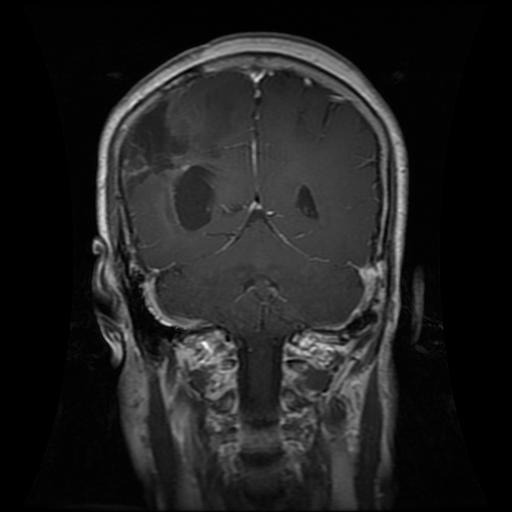

In [11]:
# Create a list of file paths for glaucoma images
positive_images = list(data_dir.glob('Training/glioma/*'))
# Open and display the first glaucoma image in the list
PIL.Image.open(str(positive_images[0]))


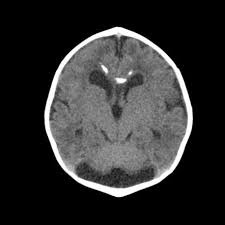

In [12]:
# Normal
normal_images = list(data_dir.glob('Training/notumor/*'))
# Open and display the first glaucoma image in the list
PIL.Image.open(str(normal_images[0]))

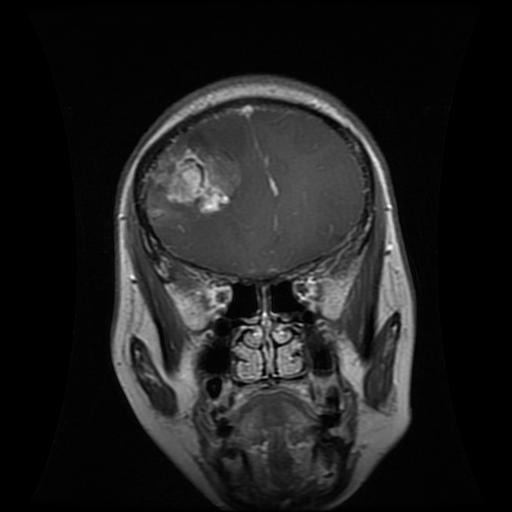

In [13]:
# BEGIN YOUR CODE HERE

# 2. Display a glioma image from the validation dataset
# Create a list of file paths for glioma images
val_glioma_images = list(data_dir.glob('Validation/glioma/*'))

# Open and display the first glioma image in the list
PIL.Image.open(str(val_glioma_images[0]))


# END YOUR CODE HERE

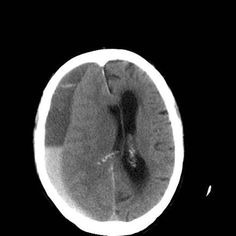

In [14]:
# BEGIN YOUR CODE HERE

# 2. Display a normal image from the validation dataset

# Create a list of file paths for the no tumour images
val_notumor_images = list(data_dir.glob('Validation/notumor/*'))

# Open and display the first  image in the list
PIL.Image.open(str(val_notumor_images[0]))


# END YOUR CODE HERE

# Define a deep learning model that will learn the differences between glioma, pituitary and normal brain images


In [15]:
# Define batch size and image dimensions for training

# BEGIN YOUR CODE HERE
# The batch size is the number of samples processed before the model is updated.
# Choose an appropriate batch size.

batch_size = 32


# What is the resolution of the images?
# Specify the size to resize images to after they are read from disk.
# Since the pipeline processes batches of images that must all have the same size, this must be provided.

img_height = 180
img_width = 180


# END YOUR CODE HERE

In [16]:
train_data_dir  = os.path.join(data_dir,'Training')
valid_data_dir = os.path.join(data_dir,'Validation')
test_data_dir = os.path.join(data_dir,'Testing')

In [17]:
# Create a TensorFlow image dataset from a directory
# BEGIN YOUR CODE HERE
# Use the function tf.keras.utils.image_dataset_from_directory to load
# the training dataset: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# 1. First argument is your training directory folder (train_data_dir),
# 2. Do NOT use validation_split since we only want a training set,
# 3. You can set a seed such that when you repeat experiments you get similar results, e.g. seed=123,
# 4. For image size, use the img_height and img_width variables you defined previously,
# 5. For batch size, use the batch_size variable you defined earlier in the code.
# tf.keras.utils.image_dataset_from_directory(
#     directory,
#     seed=123,
#     image_size=(height, width),
#     batch_size=-1,
#     shuffle=False
# )
# Example:

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)


# END YOUR CODE HERE

Found 2550 files belonging to 3 classes.
Found 450 files belonging to 3 classes.
Found 900 files belonging to 3 classes.


In [18]:
# Create a layer to normalise pixel values to the [0, 1] range.
# By default, when you load an image, each pixel value will have a value between 0-255
# but, in neural networks, we need as input normalised values in [0,1] interval.
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

print(f"Normalized DS: {normalized_ds.take(1)}")
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image), first_image[0][0])
print(train_ds.class_names)

Normalized DS: <_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
0.0 1.0 tf.Tensor([0.01123517 0.01123517 0.01123517], shape=(3,), dtype=float32)
['glioma', 'notumor', 'pituitary']


In [20]:
# BEGIN YOUR CODE HERE
# Define the number of classes in the classification problem
# How many classes do we have in this dataset?
# num_classes = TODO
num_classes = len(train_ds.class_names)

count = normalized_ds.cardinality().numpy()
print("Training Dataset (normalized) count: ", count)

num_batches = 0
for (x, y) in normalized_ds:
    num_batches += 1
print("NUM BATCHES: ", num_batches)

# Inspect First Batch!
for x, y in normalized_ds.take(1):
    print("X shape:", x.shape)
    print("Y shape:", y.shape)

# for (x, y) in normalized_ds:
#     print(y.numpy().shape)
#print(normalized_ds)


# END YOUR CODE HERE

Training Dataset (normalized) count:  80
NUM BATCHES:  80
X shape: (32, 180, 180, 3)
Y shape: (32,)


In [21]:
# BEGIN YOUR CODE HERE
# Define a tensorflow model using the tf.keras.Sequential class: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# The last layer should be a Dense layer with the number of output neurons num_classes
# Use as a starting point the tf.keras.Sequential model defined for the MNIST problem.
# See Lab-DeepLearning-ImageClassification.
# For the first Conv2D layer, you are not required to specify the input shape. If that
# parameter is not given, tensorflow library will infer the size of the input when
# you fit the model, so it will depend on the size of the dataset.
# Important: change the output of the last Dense layer to match the number of classes for this problem.
# If you don't use any of the Dropout layers what accuracy do you get?
# What accuracy do you get with the Dropout layers?

# -------------------------
# Model definition (CNN)
# -------------------------
# MY EXPLANAION: This block defines a compact CNN. Grouped explanation:
# - Rescaling (again) to ensure model input normalized.
# - Three Conv2D + MaxPool blocks progressively increase filters (16->32->64) to learn features.
# - Flatten -> Dense(128) acts as classifier head; Dropout for regularization.
# - Final Dense outputs 'num_classes' logits (no softmax here; loss uses from_logits=True).
# This architecture is fine for a teaching example but a real medical use-case benefits from
# transfer learning and stronger regularization / augmentation.
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes) ])



# END YOUR CODE HERE


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']) # Monitor accuracy and F1 score during training



C:\Sujeet\PyWorkspace\ai_ml_tutor_examples\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Extract training labels
y_train = np.concatenate([y for x, y in train_ds], axis=0)

'''
REMEMBER

no.min(..)
np.max(...)
np.avg(...)
np.unique(...)
'''

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)
print("Y_train Shape:", y_train.shape)
print("Y_train", y_train)

# TIP: Search how you can use the class weights during training to improve your results

Class Weights: {0: np.float64(1.7), 1: np.float64(0.5483870967741935), 2: np.float64(1.7)}
Y_train Shape: (2550,)
Y_train [2 0 1 ... 1 1 0]


In [24]:
# BEGIN YOUR CODE HERE
# Train the model on the provided dataset for a specified number of epochs
# Modify the network architecture such that you maximise the accuracy.
# Tip: aim to get an accuracy of at least 70% on the training set.
# For this, you can use the function fit, as in model.fit(...)
# The first argument is the train_ds variable defined above.
# This variable contains both the x (data - glaucoma and normal images) and y
# (labels - glaucoma vs normal).
# Start training using 5 epochs. What is the accuracy you get?
# How about if you increase the number of epochs?
# Use as validation_data the val_ds variable you defined previously


# -------------------------
# Training
# -------------------------
# MY EXPLANAION: Fit the model on train_ds with validation on val_ds. Class weights influence
# the loss for each class to address imbalance. 'epochs' controls number of passes over data.
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

# END YOUR CODE HERE

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8737 - loss: 0.3335 - val_accuracy: 0.8133 - val_loss: 0.4706
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.9565 - loss: 0.1285 - val_accuracy: 0.7533 - val_loss: 0.7084
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9729 - loss: 0.0722 - val_accuracy: 0.6711 - val_loss: 1.2000
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9882 - loss: 0.0366 - val_accuracy: 0.6044 - val_loss: 1.7404
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9745 - loss: 0.0660 - val_accuracy: 0.8489 - val_loss: 0.4036
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9961 - loss: 0.0151 - val_accuracy: 0.7778 - val_loss: 0.8849
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - accuracy: 0.9973 - loss: 0.0073 - val_accuracy: 0.7067 - val_loss: 1.4156
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.9980 - loss: 0.0087 - val_accuracy: 0.

In [27]:
from scipy.ndimage import gaussian_filter1d  # for smoothing

# -------------------------
# Plot training curves (loss & accuracy)
# -------------------------
# MY EXPLANAION: This grouped block extracts training history and plots loss/accuracy for
# both train and val. A gaussian filter is used to smooth the curves for clearer trends.

# function to plot loss/accuracy with trend lines
def plot_loss_accuracy(history, smooth_sigma=2):
    # Extract loss and accuracy values
    loss_values = history.history['loss']
    acc_values = history.history['accuracy']

    # Validation (if available)
    val_loss = history.history.get('val_loss')
    val_acc = history.history.get('val_accuracy')

    epochs = np.arange(1, len(loss_values) + 1)

    # --- Plot Training & Validation Loss ---
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', alpha=0.5, label='Training Loss')
    plt.plot(epochs, gaussian_filter1d(loss_values, sigma=smooth_sigma), color='b', linewidth=2, label='Trend (Train)')

    if val_loss is not None:
        plt.plot(epochs, val_loss, marker='x', linestyle='--', color='r', alpha=0.5, label='Validation Loss')
        plt.plot(epochs, gaussian_filter1d(val_loss, sigma=smooth_sigma), color='r', linewidth=2, label='Trend (Val)')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    # --- Plot Training & Validation Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_values, marker='o', linestyle='-', color='g', alpha=0.5, label='Training Accuracy')
    plt.plot(epochs, gaussian_filter1d(acc_values, sigma=smooth_sigma), color='g', linewidth=2, label='Trend (Train)')

    if val_acc is not None:
        plt.plot(epochs, val_acc, marker='x', linestyle='--', color='orange', alpha=0.5, label='Validation Accuracy')
        plt.plot(epochs, gaussian_filter1d(val_acc, sigma=smooth_sigma), color='orange', linewidth=2, label='Trend (Val)')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

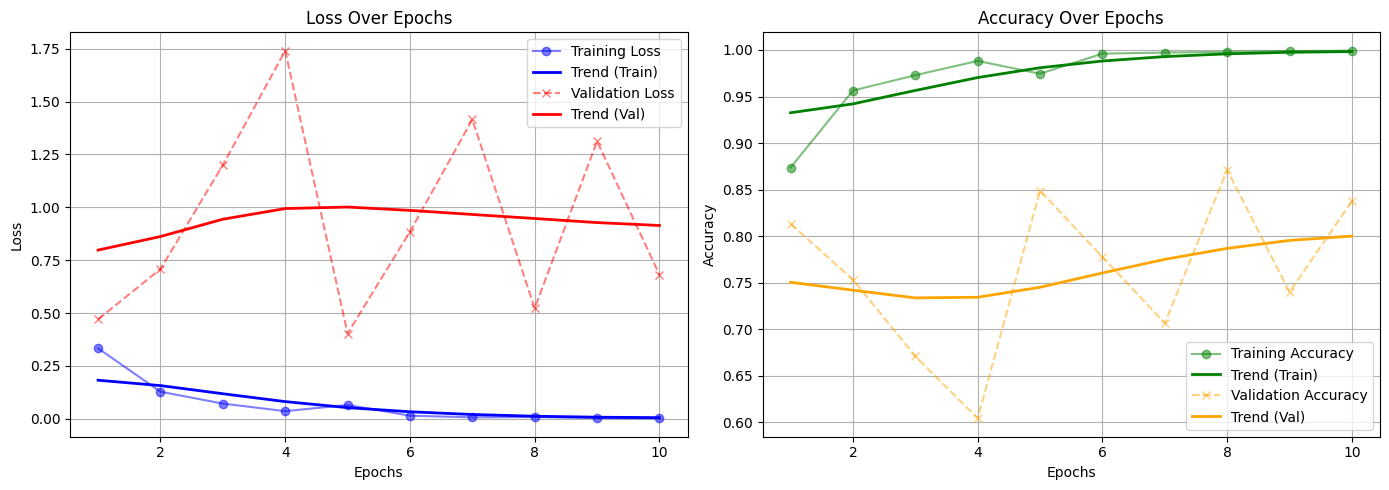

In [26]:
plot_loss_accuracy(history)

In [28]:
# Let's load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False   # 🔑 Ensure labels line up with predictions
)




Found 900 files belonging to 3 classes.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9000 - loss: 0.5623
Test loss: 0.5622602701187134
Test accuracy: 0.8999999761581421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

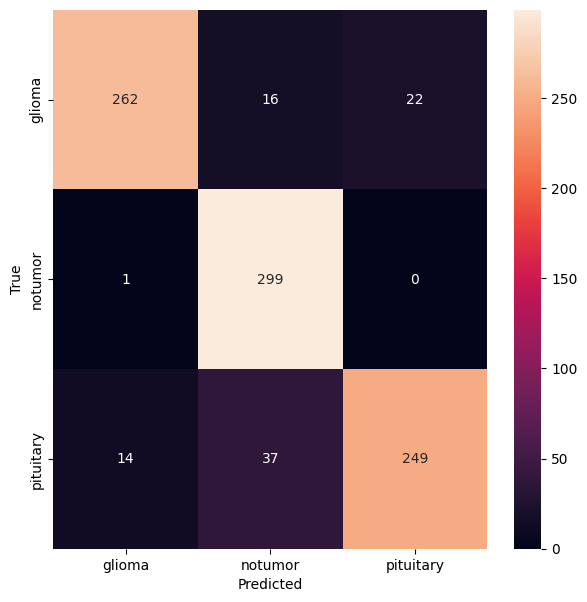

In [29]:
# BEGIN YOUR CODE HERE
# What is the loss and accuracy on the Testing dataset?
# Compute and plot the confusion matrix on the test dataset
# Tip: instead of (x_test, y_test) we used in the lab last week, you can use
# directly test_ds which contains both data and labels
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
# When you print the output of the evaluate function is run, it will return both
# the loss and accuracy, maybe in a  format like [loss_value, accuracy_value]
# print("Model accuracy on the test set is:", model.evaluate(test_ds))
# Display the confusion matrix, precision, recall and f1-score

test_results = model.evaluate(test_ds)
print("Test loss:", test_results[0])
print("Test accuracy:", test_results[1])

#-------------------------
# Predictions, confusion matrix, classification report
# -------------------------
# MY EXPLANAION: Iterate the test dataset to gather true labels and model predictions. Since the model
# outputs logits, argmax converts to predicted class index. The confusion matrix and sklearn
# classification_report summarize per-class performance (precision, recall, f1).
y_true = []
y_pred = []

class_names = train_ds.class_names

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()


# END YOUR CODE HERE

In [30]:

# -------------------------
# Final notes & improvements (grouped suggestions)
# -------------------------
# MY EXPLANAION: The following are grouped practical recommendations to improve model robustness
# and reliability in medical imaging contexts:
#
# - Data Augmentation: add tf.keras.layers.RandomFlip, RandomRotation, RandomZoom in preprocessing to reduce overfitting.
# - Transfer Learning: use pretrained backbones (EfficientNet, MobileNetV2) and fine-tune; this often outperforms small CNNs.
# - Callbacks: use EarlyStopping, ModelCheckpoint to prevent overtraining and save the best model.
# - Metrics: track sensitivity/recall and AUC in addition to accuracy in imbalanced/medical tasks.
# - Reproducibility: set tf.random.set_seed, np.random.seed and log environment (TF, CUDA versions).
# - Evaluation: consider stratified K-fold cross-validation for small datasets and detailed case-level error analysis.
#
# Implementing these as code changes is straightforward; let me know if you want a modified script that
# integrates augmentation + transfer learning + callbacks and saves a model artifact.



In [ ]:
# Try to improve the model such that it performs well on both training and testing datasets.